# Large-Scale Non-linear Dynamical System 

This notebook does not perform any becnhmark and simply runs the inference procedure and generates some nice plots for the thesis.

_Author: Dmitry Bagaev_

In [1]:
using DrWatson

In [2]:
@quickactivate "RxInferThesisExperiments"

In [3]:
using RxInferThesisExperiments, RxInfer, StaticArrays, Plots, PGFPlotsX, LaTeXStrings
using LinearAlgebra, StableRNGs, Random, BenchmarkTools, ColorSchemes, Dates

In [4]:
# For the thesis I use the `pgfplotsx` backend of the `Plots`, since it generates high-quiality plots
# But it is reallyyy slow, if some wants to generate plots faster uncoment the `gr()` line
pgfplotsx()

# Use fast plotting backend
# gr()

Plots.PGFPlotsXBackend()

In [5]:
# Pregenerate paths for plots 
mkpath(plotsdir("nlds"));

## Double pendulum environment

In [7]:
# Create default environment with default parameters
const environment = DoublePendulum()

DoublePendulum()

In [8]:
# Define state-transition function, uses RK4 method internally, see the `src/` folder
f(state) = state_transition(environment)(state)

f (generic function with 1 method)

In [9]:
# Include the model specification
include(srcdir("models", "rxinfer", "double_pendulum.jl"));

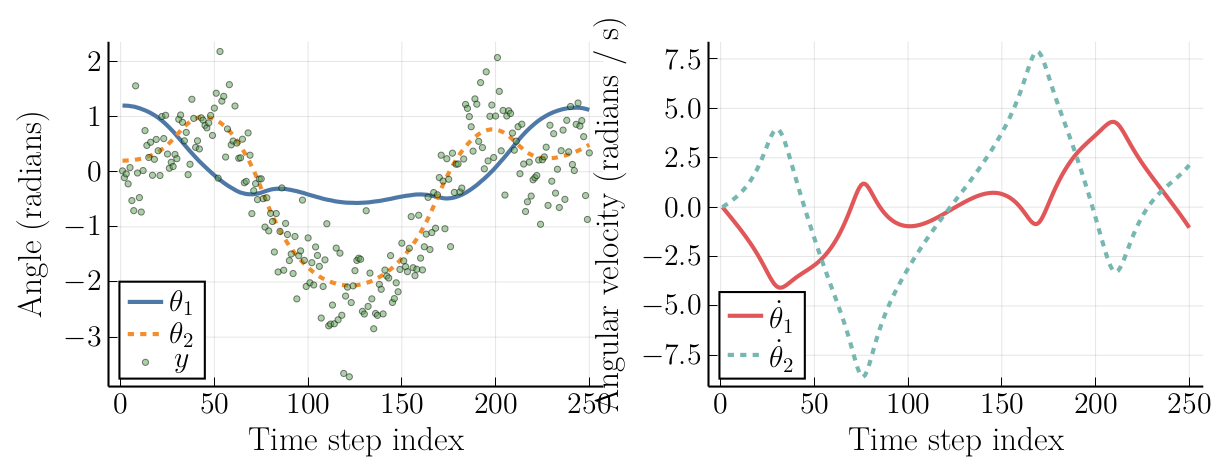

In [10]:
# For plotting purposes I only generate 250 points
T = 250
rng = StableRNG(42)

states, observations = rand(rng, environment, T);

# `plotting`range
prange = firstindex(states):lastindex(states)
colors = ColorSchemes.tableau_10

# Some default settings for plotting
pfontsettings = (
    titlefontsize=18,
    guidefontsize=16,
    tickfontsize=14,
    legendfontsize=14,
    legend = :bottomleft,
    size = (400, 300)
)

p1 = plot(xlabel = "Time step index", ylabel = "Angle (radians)"; pfontsettings...)
p1 = plot!(prange, getindex.(states, 1)[prange], color = colors[1], linewidth = 2, label = L"\theta_1")
p1 = plot!(p1, prange, getindex.(states, 2)[prange], color = colors[2], linewidth = 2, label = L"\theta_2", style = :dash)
p1 = scatter!(p1, prange, observations[prange], ms = 2, msw = 0, color = colors[5], alpha = 0.5, label = L"y")

p2 = plot(xlabel = "Time step index", ylabel = "Angular velocity (radians / s)"; pfontsettings...)
p2 = plot!(p2, prange, getindex.(states, 3)[prange], color = colors[3], linewidth = 2, label = L"\dot{\theta}_1")
p2 = plot!(p2, prange, getindex.(states, 4)[prange], color = colors[4], linewidth = 2, label = L"\dot{\theta}_2", style = :dash)

savefig(p1, plotsdir("nlds", "pendulum_example_angles.tex"))
savefig(p2, plotsdir("nlds", "pendulum_example_velocities.tex"))

plot(p1, p2, layout = @layout([ a b ]), size = (800, 300))

In [18]:
# First invoke slow as usual, but we do not perform benchmarks here so it does not really matter
# We perform a small benchmark below, for that we need to wrap the `inference` call in a separate function
function run_inference(T, fstate, observations)
    return inference(
        model = double_pendulum(T, fstate),
        data = (y = observations, ),
        meta = double_pendulum_meta(),
        constraints = double_pendulum_constraints(),
        returnvars = (s = KeepLast(), ),
        iterations = 3,
        initmarginals = (σ = Gamma(0.001, 100.0), ),
        options = (limit_stack_depth = 500, )
    )
end

run_inference (generic function with 2 methods)

In [12]:
results = run_inference()

Inference results:
  Posteriors       | available for (s)


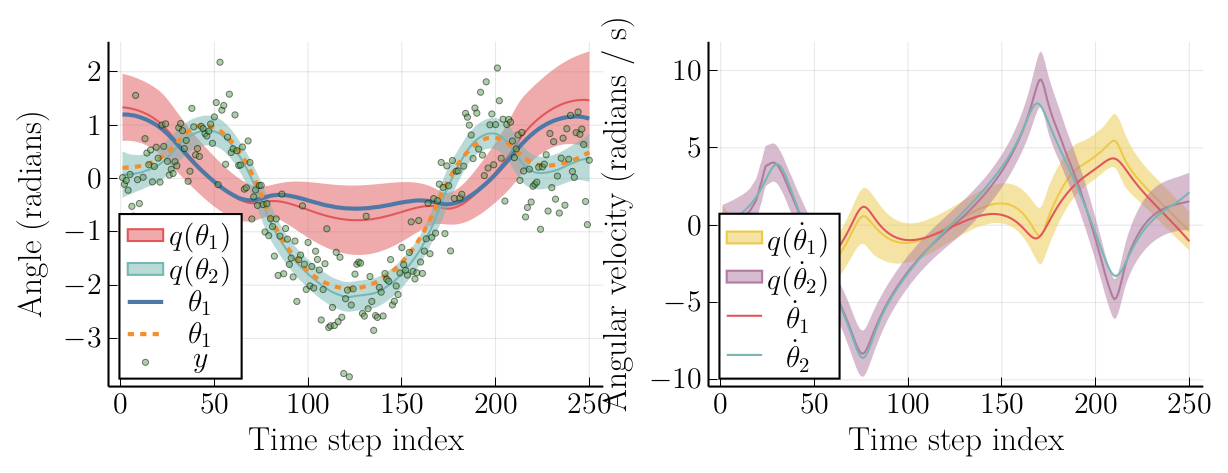

In [13]:
em = mean.(results.posteriors[:s])
ev = std.(results.posteriors[:s])
p1 = plot(xlabel = "Time step index", ylabel = "Angle (radians)"; pfontsettings...)

plot!(prange, getindex.(em, 1)[prange], color = colors[3], ribbon = 3getindex.(ev, 1, 1), label = L"q(\theta_1)")
plot!(prange, getindex.(em, 2)[prange], color = colors[4], ribbon = 3getindex.(ev, 2, 2), label = L"q(\theta_2)")
plot!(prange, getindex.(states, 1)[prange], label = L"\theta_1", color = colors[1], linewidth = 2,)
plot!(prange, getindex.(states, 2)[prange], label = L"\theta_1", color = colors[2], linewidth = 2, style = :dash)
scatter!(prange, getindex.(observations, 1)[prange], ms = 2, msw = 0, alpha = 0.5, color = colors[5], label = L"y")

p2 = plot(size=(800, 300), xlabel = "Time step index", ylabel = "Angular velocity (radians / s)"; pfontsettings...)
plot!(prange, getindex.(em, 3)[prange], ribbon = 3getindex.(ev, 3, 3), color = colors[6], label = L"q(\dot{\theta}_1)")
plot!(prange, getindex.(em, 4)[prange], ribbon = 3getindex.(ev, 4, 4), color = colors[7], label = L"q(\dot{\theta}_2)")
plot!(prange, getindex.(states, 3)[prange], color = colors[3], label = L"\dot{\theta}_1")
plot!(prange, getindex.(states, 4)[prange], color = colors[4], label = L"\dot{\theta}_2")

savefig(p1, plotsdir("nlds", "pendulum_example_inference_angles.tex"))
savefig(p2, plotsdir("nlds", "pendulum_example_inference_velocities.tex"))

plot(p1, p2, size = (800, 300), layout = @layout([ a b ]))

## Small benchmark

In [20]:
benchmark = @benchmark run_inference($T, $(states[begin]), $observations)

BenchmarkTools.Trial: 96 samples with 1 evaluation.
 Range (min … max):  35.493 ms … 76.621 ms  ┊ GC (min … max):  0.00% … 21.18%
 Time  (median):     54.513 ms              ┊ GC (median):    31.33%
 Time  (mean ± σ):   52.216 ms ±  7.909 ms  ┊ GC (mean ± σ):  26.00% ± 12.34%

                       ▂       ▂ ▆█▂▄▆▄                        
  ▄▆▁▄▆█▄▄▆▆▄▁▁▁▁▄█▆▁█▆██▆▄▆▆▁▁████████▆▆█▆▁▄▁▁▁▄▁▄▄▁▁▁▁▁▁▁▁▄ ▁
  35.5 ms         Histogram: frequency by time        71.7 ms <

 Memory estimate: 36.34 MiB, allocs estimate: 321578.

In [15]:
# I also print some basic statitistic over the benchmark result
m_times = minimum(benchmark)
# Check how much time does it take to execute the inference procedure
m_execution_time = round(Dates.Nanosecond(m_times.time), Dates.Millisecond)
m_execution_time_no_gc = round(Dates.Nanosecond(m_times.time - m_times.gctime), Dates.Millisecond)

m_time_per_point = round(Dates.Nanosecond(round((m_times.time) / T)), Dates.Microsecond)
m_time_per_point_no_gc = round(Dates.Nanosecond(round((m_times.time - m_times.gctime) / T)), Dates.Microsecond)

println("Execution time (with GC) ", m_execution_time)
println("Execution time (without GC) ", m_execution_time_no_gc)

println("Execution time per observation (with GC) ", m_time_per_point)
println("Execution time per observation (without GC) ", m_time_per_point_no_gc)

Execution time (with GC) 35 milliseconds
Execution time (without GC) 35 milliseconds
Execution time per observation (with GC) 141 microseconds
Execution time per observation (without GC) 141 microseconds


## Versions

In [16]:
versioninfo()

Julia Version 1.9.0
Commit 8e630552924 (2023-05-07 11:25 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin22.4.0)
  CPU: 12 × Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, skylake)
  Threads: 2 on 12 virtual cores


In [17]:
] status

Project RxInferThesisExperiments v1.0.0
Status `~/.julia/dev/thesis/Project.toml`
  [6e4b80f9] BenchmarkTools v1.3.2
  [35d6a980] ColorSchemes v3.21.0
⌃ [31c24e10] Distributions v0.25.94
  [634d3b9d] DrWatson v2.12.5
  [f6369f11] ForwardDiff v0.10.35
  [7073ff75] IJulia v1.24.0
  [b964fa9f] LaTeXStrings v1.3.0
  [3bd65402] Optimisers v0.2.18
  [8314cec4] PGFPlotsX v1.6.0
  [e4faabce] PProf v2.2.2
⌃ [91a5bcdd] Plots v1.38.12
  [37e2e3b7] ReverseDiff v1.14.6
  [86711068] RxInfer v2.10.4
  [860ef19b] StableRNGs v1.0.0
  [aedffcd0] Static v0.8.7
  [90137ffa] StaticArrays v1.5.25
  [fce5fe82] Turing v0.25.1
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random
Info Packages marked with ⌃ have new versions available and may be upgradable.
